<a href="https://colab.research.google.com/github/Aadarsh-07/Convulational-Variational-AutoEncoder/blob/main/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

In [26]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.0  # Normalize to [0, 1]
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.0

In [30]:
latent_dim = 20
batch_size = 128
num_epochs = 20

In [35]:
class CVAE(Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder network
        self.encoder_conv = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten()
        ])
        self.encoder_mu = layers.Dense(latent_dim)       # Mean
        self.encoder_logvar = layers.Dense(latent_dim)   # Log variance

        # Decoder network
        self.decoder_fc = layers.Dense(7 * 7 * 64, activation='relu')  # Reshape latent space
        self.decoder_conv = tf.keras.Sequential([
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def encode(self, x):
        """Encode input into latent space."""
        x = self.encoder_conv(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + sigma * epsilon."""
        epsilon = tf.random.normal(shape=tf.shape(mu))
        std = tf.exp(0.5 * logvar)
        return mu + std * epsilon

    def decode(self, z):
        """Decode latent vector into image."""
        x = self.decoder_fc(z)
        x = self.decoder_conv(x)
        return x

    def call(self, x):
        """Full forward pass."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def compute_loss(model, x):
    # Forward pass through the model
    recon, mu, logvar = model(x)

    # Reconstruction Loss (manually calculate MSE)
    recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - recon), axis=[1, 2, 3]))  # MSE over batch

    # KL Divergence Loss
    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))

    # Total Loss
    return recon_loss + kl_loss, recon_loss, kl_loss



In [36]:
model = CVAE(latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [37]:
train_df = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)
test_df = tf.data.Dataset.from_tensor_slices((x_test, x_test)).batch(batch_size)

In [38]:
for epoch in range(num_epochs):
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch in train_df:
        with tf.GradientTape() as tape:
            loss, recon_loss, kl_loss = compute_loss(model, batch)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        train_loss += loss.numpy()
        train_recon_loss += recon_loss.numpy()
        train_kl_loss += kl_loss.numpy()

    avg_loss = train_loss / len(train_df)
    avg_recon_loss = train_recon_loss / len(train_df)
    avg_kl_loss = train_kl_loss / len(train_df)

    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Loss: {avg_kl_loss:.4f}")

Epoch 1/20, Total Loss: 88.5493, Recon Loss: 88.4869, KL Loss: 0.0624
Epoch 2/20, Total Loss: 63.3937, Recon Loss: 63.3880, KL Loss: 0.0057
Epoch 3/20, Total Loss: 52.8917, Recon Loss: 52.8916, KL Loss: 0.0000
Epoch 4/20, Total Loss: 52.8425, Recon Loss: 52.8425, KL Loss: 0.0000
Epoch 5/20, Total Loss: 52.8186, Recon Loss: 52.8186, KL Loss: 0.0000
Epoch 6/20, Total Loss: 52.8118, Recon Loss: 52.8118, KL Loss: 0.0000
Epoch 7/20, Total Loss: 52.7998, Recon Loss: 52.7998, KL Loss: 0.0000
Epoch 8/20, Total Loss: 52.7957, Recon Loss: 52.7956, KL Loss: 0.0000
Epoch 9/20, Total Loss: 52.7941, Recon Loss: 52.7941, KL Loss: 0.0000
Epoch 10/20, Total Loss: 52.7857, Recon Loss: 52.7856, KL Loss: 0.0000
Epoch 11/20, Total Loss: 52.7852, Recon Loss: 52.7852, KL Loss: 0.0000
Epoch 12/20, Total Loss: 52.7773, Recon Loss: 52.7772, KL Loss: 0.0000
Epoch 13/20, Total Loss: 52.7809, Recon Loss: 52.7809, KL Loss: 0.0000
Epoch 14/20, Total Loss: 52.7725, Recon Loss: 52.7725, KL Loss: 0.0000
Epoch 15/20, To

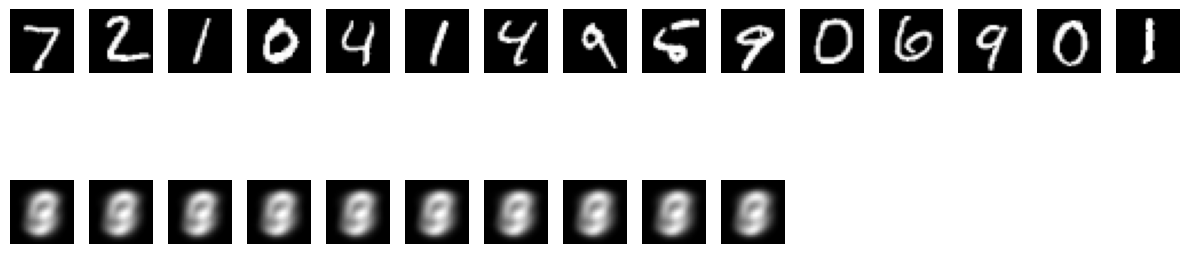

In [47]:
# Test the CVAE model and visualize results
for test_batch in test_df.take(1):  # Take one batch from the test dataset
    recon_images, _, _ = model(test_batch)  # Directly run the model on test data

# Visualization
plt.figure(figsize=(12, 4))
for i in range(15):
    # Original Images
    plt.subplot(2, 15, i + 1)
    plt.imshow(test_batch[0][i].numpy().squeeze(), cmap='gray')
    plt.axis('off')

    # Reconstructed Images
    plt.subplot(2, 15, i + 11)
    plt.imshow(recon_images[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()
